In [1]:
import tensorflow as tf
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error

# gloabl params for all matplotlib plots
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2023-07-23 20:32:32.446673: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset

In [2]:
df = pd.read_csv('../datasets/clean_data.csv')
df.head()

,Date,Spx,Gold,Btc,Dji,Eth,Copper,Oil,Gas,Silver,USD
0,2017-01-03,2257.83,1163.2,1037.5,19881.76,9.74,2.4890,52.33,3.327,16.409,103.146
1,2017-01-04,2270.75,1166.5,1139.6,19942.16,11.00,2.5565,53.26,3.267,16.552,102.649
2,2017-01-05,2269.00,1182.6,1003.2,19899.29,10.15,2.5375,53.76,3.273,16.637,101.453
3,2017-01-06,2276.98,1174.8,898.0,19963.80,10.08,2.5460,53.99,3.285,16.519,102.139
4,2017-01-09,2268.90,1186.3,903.0,19887.38,10.26,2.5385,51.96,3.103,16.683,101.844


In [3]:
# Features
features_considered = ['Spx', 'Dji', 'Gold', 'Eth']

features = df[features_considered]
features.index = df['Date']
features.head()

,Spx,Dji,Gold,Eth
Date,,,,
2017-01-03,2257.83,19881.76,1163.2,9.74
2017-01-04,2270.75,19942.16,1166.5,11.00
2017-01-05,2269.00,19899.29,1182.6,10.15
2017-01-06,2276.98,19963.80,1174.8,10.08
2017-01-09,2268.90,19887.38,1186.3,10.26


In [4]:
# Standardize data
data_mean = features.mean(axis=0)
data_std = features.std(axis=0)
features = (features - data_mean) / data_std

# Inverse scaling
unscaled_features = (features * data_std) + data_mean

## Train-Val-Test split

In [5]:
# Compute the index values for slicing the dataset
total_size = len(unscaled_features)
train_size = int(total_size * 0.8)
val_size = int(total_size * 0.1)

# Slice the standardized features dataset into train-validation-test sets
train_data = unscaled_features[:train_size]
val_data = unscaled_features[train_size:train_size+val_size]
test_data = unscaled_features[train_size+val_size:]

# Calculate the mean of the series
mean = unscaled_features.mean()
print("Mean of the series:\n", mean)

Mean of the series:
 Spx      3282.708394
Dji     27837.383826
Gold     1552.489443
Eth       992.669750
dtype: float64


**Forecasting task:**  Predict Spx in the future.




## Moving window average

### MWA: 
Average the previous k values to predict the next value.

In [6]:
#utility function
def create_time_steps(length):
  return list(range(-length, 0))

print(create_time_steps(20))

[-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


In [7]:
# New params:
# step: instead of taking data for each day, do you want to generate data once evrey 6 steps (6 days)
# single_step: lables from single timestamp or multiple timesteps

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step) # step used here.
    data.append(dataset[indices])

    if single_step: # single_step used here.
      labels.append(target[i+target_size]) 
    else:
      labels.append(target[i:i+target_size]) 

  return np.array(data), np.array(labels)

In [8]:
# Plot train and validation loss over epochs

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.grid()

  plt.show()

#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [9]:
def plot_predictions(val_data, model):
    for x, y in val_data.take(4): # b4: val_data_multi
      multi_step_plot(x[0], y[0], model.predict(x)[0]) # b4: multi_step_model    

In [10]:
# TF Dataset preperation
tf.random.set_seed(111) # random seed 
past_history = 5
future_target = 5 # 5 future values
STEP = 1
# past history possible values: 22 => a business month; 10 two bisiness weeks; 5 => a business week 
# future_target: 5 = > 5 in the future, not next day
BATCH_SIZE = 86 # bacth size in batch-SGD/variants
EPOCHS = 30
STEPS_PER_EPOCH = 50
BUFFER_SIZE = 888 # for shuffling the dataset

## Multi-variate & multi-step forecasting

In [11]:
target_variable = 'Spx'
train_target_data = train_data[target_variable].values
train_feature_data = train_data.drop(target_variable, axis=1).values
###
val_target_data = val_data[target_variable].values
val_feature_data = val_data.drop(target_variable, axis=1).values
###
test_target_data = test_data[target_variable].values
test_feature_data = test_data.drop(target_variable, axis=1).values

In [12]:
x_train_multi, y_train_multi = multivariate_data(train_feature_data, train_target_data, 0,
                                                 None, past_history,
                                                 future_target, STEP)

x_val_multi, y_val_multi = multivariate_data(val_feature_data, val_target_data,
                                             0, None, past_history,
                                             future_target, STEP)

x_test_multi, y_test_multi = multivariate_data(test_feature_data, test_target_data,
                                               0, None, past_history,
                                               future_target, STEP)


In [13]:
print(x_train_multi.shape)
print(y_train_multi.shape)

print(x_val_multi.shape)
print(y_val_multi.shape)

(1240, 5, 3)
(1240, 5)
(146, 5, 3)
(146, 5)


In [14]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

test_data_multi = tf.data.Dataset.from_tensor_slices((x_test_multi, y_test_multi))
test_data_multi = test_data_multi.batch(BATCH_SIZE)  # remove repeat() method

2023-07-23 20:32:37.182712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [1240,5]
	 [[{{node Placeholder/_1}}]]
2023-07-23 20:32:37.193946: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


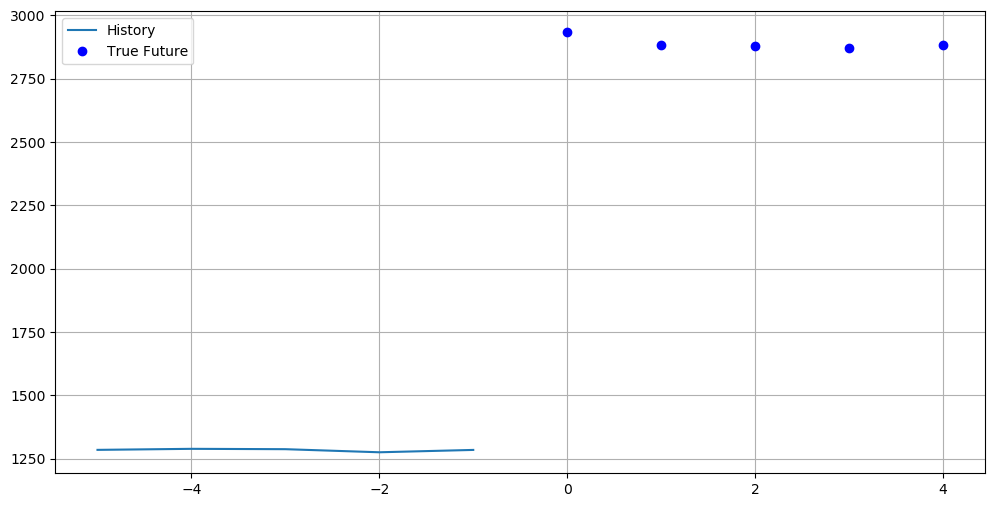

In [15]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [16]:
activation_functions = np.array([
    'sigmoid',
    'tanh',
    'relu',
    'leaky_relu',
    'elu',
    'softmax',
    'swish',
    'gelu',
])

## Modeling

Epoch 1/100


2023-07-23 20:32:37.690202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-23 20:32:37.692631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-23 20:32:37.694392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

260/265 [============================>.] - ETA: 0s - loss: 3303.4478

2023-07-23 20:32:44.487045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [146,5]
	 [[{{node Placeholder/_1}}]]
2023-07-23 20:32:44.757783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-23 20:32:44.760092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor '

265/265 [==============================] - 8s 11ms/step - loss: 3305.3250 - val_loss: 4727.2935
Epoch 2/100
265/265 [==============================] - 2s 9ms/step - loss: 3296.2046 - val_loss: 4719.4082
Epoch 3/100
265/265 [==============================] - 2s 9ms/step - loss: 3292.7058 - val_loss: 4711.6729
Epoch 4/100
265/265 [==============================] - 2s 9ms/step - loss: 3281.9224 - val_loss: 4704.0981
Epoch 5/100
265/265 [==============================] - 2s 9ms/step - loss: 3273.0327 - val_loss: 4696.6699
Epoch 6/100
265/265 [==============================] - 2s 9ms/step - loss: 3270.3616 - val_loss: 4689.3745
Epoch 7/100
265/265 [==============================] - 2s 9ms/step - loss: 3259.6216 - val_loss: 4682.2358
Epoch 8/100
265/265 [==============================] - 2s 9ms/step - loss: 3252.4675 - val_loss: 4675.2295
Epoch 9/100
265/265 [==============================] - 2s 9ms/step - loss: 3248.2068 - val_loss: 4668.3569
Epoch 10/100
265/265 [==========================

265/265 [==============================] - 3s 13ms/step - loss: 166.3705 - val_loss: 301.6190
Epoch 78/100
265/265 [==============================] - 3s 10ms/step - loss: 164.8649 - val_loss: 307.8263
Epoch 79/100
265/265 [==============================] - 2s 9ms/step - loss: 164.1707 - val_loss: 296.4994
Epoch 80/100
265/265 [==============================] - 2s 9ms/step - loss: 162.5456 - val_loss: 296.6304
Epoch 81/100
265/265 [==============================] - 3s 11ms/step - loss: 161.0676 - val_loss: 295.7420
Epoch 82/100
265/265 [==============================] - 3s 11ms/step - loss: 159.2117 - val_loss: 304.5936
Epoch 83/100
265/265 [==============================] - 3s 11ms/step - loss: 158.2213 - val_loss: 274.6783
Epoch 84/100
265/265 [==============================] - 2s 9ms/step - loss: 157.6976 - val_loss: 316.9169
Epoch 85/100
265/265 [==============================] - 2s 9ms/step - loss: 156.8096 - val_loss: 302.2173
Epoch 86/100
265/265 [==============================] 

2023-07-23 20:36:42.604788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-23 20:36:42.607533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-23 20:36:42.609560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 6ms/step
MAE:  260.2335554232662
MSE:  98945.23677441207
RMSE:  314.5556179349084
MAPE:  5.691437017977627


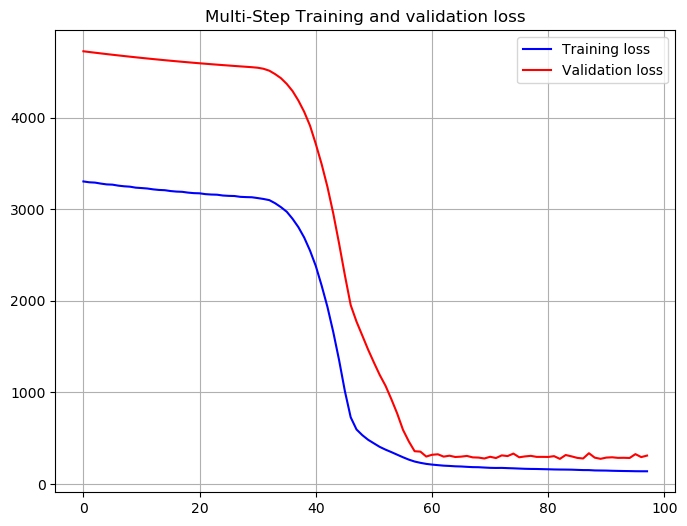

2023-07-23 20:36:43.113877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [146,5]
	 [[{{node Placeholder/_1}}]]
2023-07-23 20:36:43.392981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-23 20:36:43.395258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor '

3/3 [==============================] - 0s 3ms/step


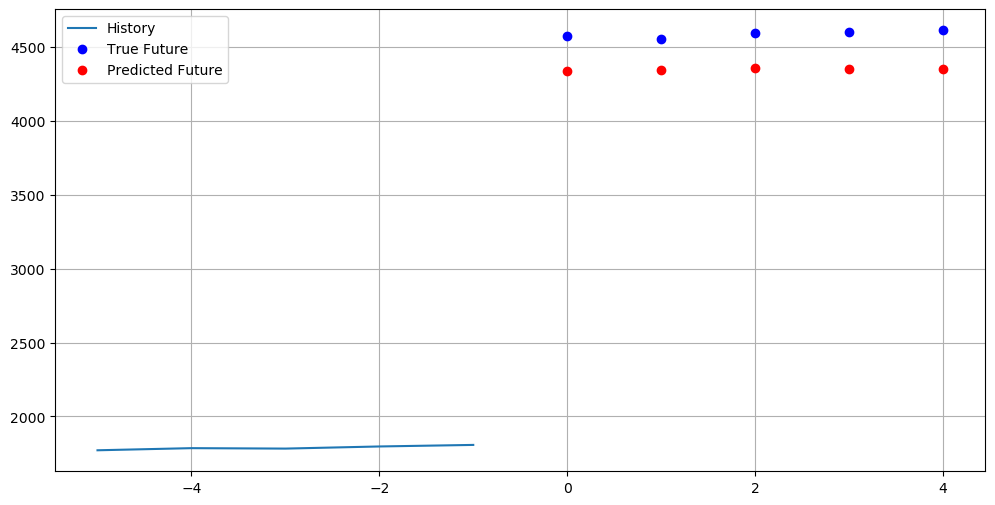

2/2 [==============================] - 0s 4ms/step


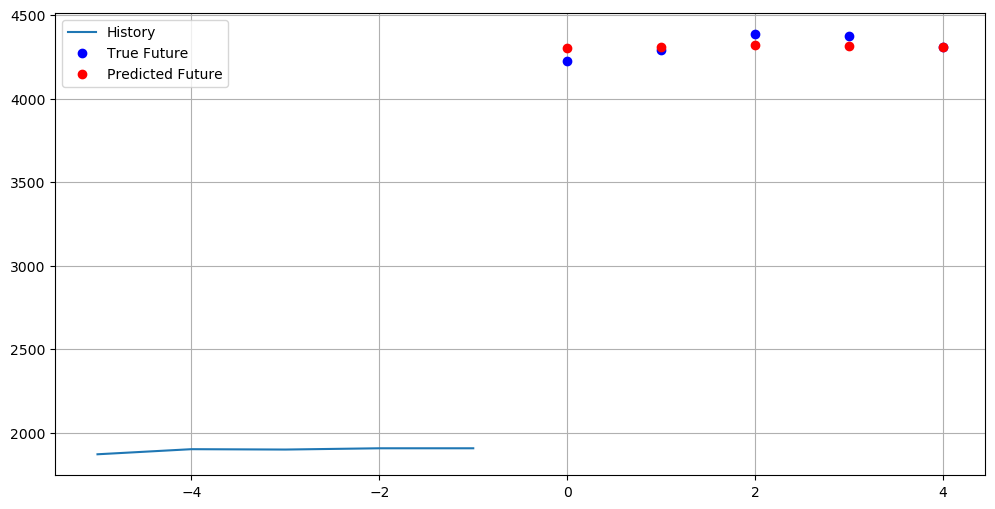

3/3 [==============================] - 0s 3ms/step


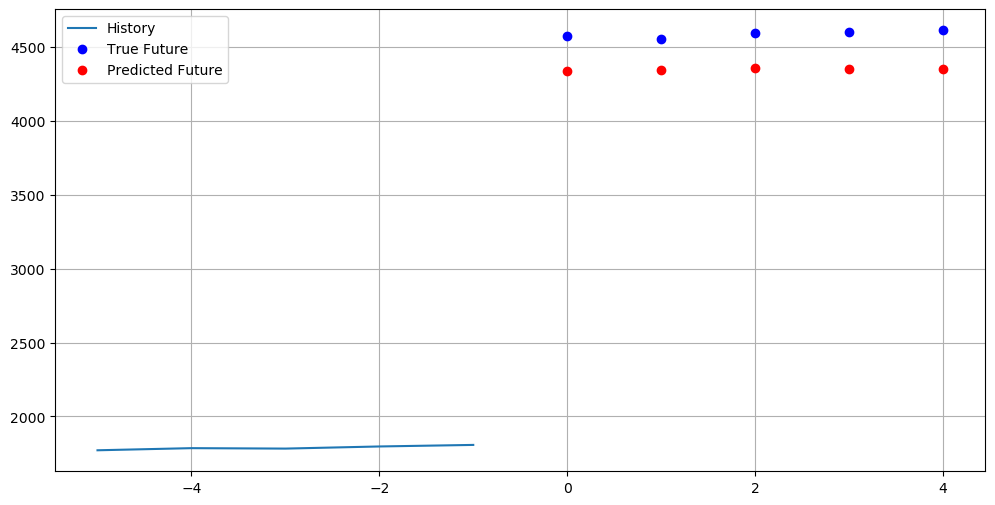

2/2 [==============================] - 0s 4ms/step


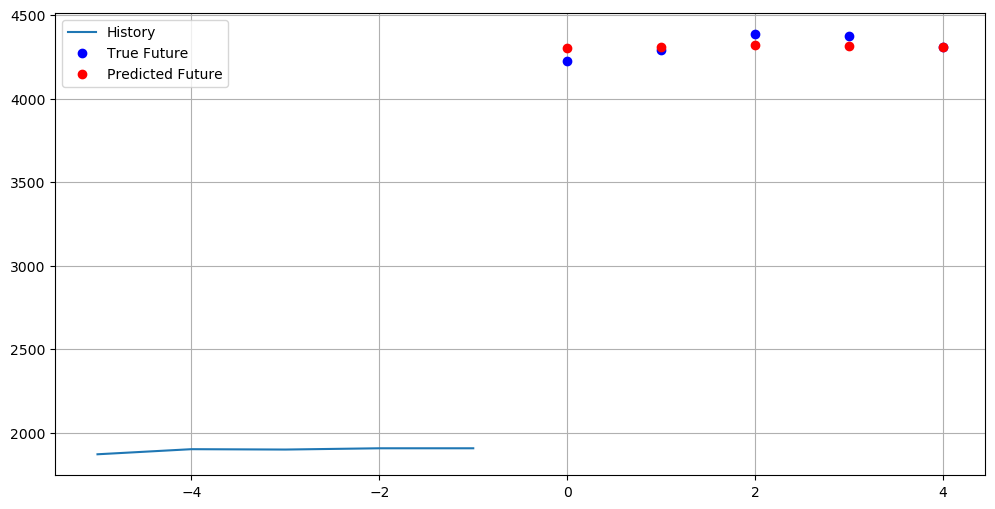

In [17]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(64,
                   return_sequences=True,
                   input_shape=x_train_multi.shape[-2:],
                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.2, l2=0.1)))
#     multi_step_model.add(tf.keras.layers.Dropout(DROPOUT_RATE))
multi_step_model.add(tf.keras.layers.LSTM(
                    32, activation=activation_functions[7],
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.3, l2=0.3)))
#     multi_step_model.add(tf.keras.layers.Dropout(DROPOUT_RATE))
multi_step_model.add(tf.keras.layers.Dense(5))
optimizer = tf.keras.optimizers.Nadam(learning_rate=10**-5)
multi_step_model.compile(optimizer=optimizer, loss='mae')
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1)

multi_step_history = multi_step_model.fit(train_data_multi,
          epochs=100,
          steps_per_epoch=265,
          validation_data=val_data_multi,
          validation_steps=80,
          callbacks=[es])
# multi_step_model.save(MODEL_NAME+'.h5')
## METRICS
val_steps = (len(y_val_multi) - 1) // BATCH_SIZE + 1
y_pred = multi_step_model.predict(val_data_multi, steps=val_steps)
# Calculate RMSE, MAE and MSE
mae = mean_absolute_error(y_val_multi, y_pred)
mse = mean_squared_error(y_val_multi, y_pred)
rmse = np.sqrt(mean_squared_error(y_val_multi, y_pred))
# Calculate MAPE
abs_error = np.abs(y_val_multi - y_pred)
pct_error = abs_error / y_val_multi * 100
mape = np.mean(pct_error)
print('MAE: ', mae)
print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAPE: ', mape)

plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')
plot_predictions(val_data_multi, multi_step_model)
# return rmse, mae, mse, mape

In [18]:
# run_model('base_lstm_model', EPOCHS=100, LSTM1_UNITS=64, LSTM2_UNITS=32, DROPOUT_RATE=0, LEARNING_RATE=-5, STEPS_PER_EPOCH=265, OPTIMIZER=6, ACTIVATION=7)